In [ ]:
cd /content/drive/MyDrive/Fun With MNIST/MNIST-2 (Binary Label Classification)

/content/drive/MyDrive/Fun With MNIST/MNIST-2 (Binary Label Classification)


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Input, Flatten, Dropout, Add, Activation, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import urllib.request
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
def create_dataset(dataset_size):
    '''
    Function to create dataset for multi label classification by horizontally stacking two images.
    Parameters:
            dataset_size = size of the dataset to be created
    Returns : New dataset with two classes in one image and size of the returned dataset will not match with dataset_size variable, since we drop few images.
    '''
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x = np.concatenate((x_train, x_test), axis = 0) #contatenating both train and test dataset to create one large dataset.
    y = np.concatenate((y_train, y_test))
    print('Shape of the dataset after concatinating:')
    print(x.shape, y.shape)

    x_new = []
    y_new = []
    no_of_removes = 0
    for _ in range(dataset_size):
        indices = np.random.randint(0, 70000, size = 2) #randomly selecting two indices for stacking.

        ans1, ans2 = y[indices[0]], y[indices[1]]

        if ans1 == ans2:  # check if both the images have same target, if yes then skip that example and donot add it to the dataset. Although this
                            # should not effect the model's performance but still for sanity check.
          no_of_removes +=1
          pass
        else:
          new_image = np.concatenate((x[indices[0]], x[indices[1]]), axis = 1)

        #   new_image = np.zeros((56, 56), np.uint8)

        #     #combine 2 images
        #   new_image[:h1, :w1] = x[indices[0]]
        #   new_image[:h2, w1:w1+w2] = x[indices[1]]
          
          x_new.append(new_image)


        # new_y = [1 if z == ans1 or z == ans2 else 0 for z in range(10)]
          y_new.append((ans1, ans2))

    print(f'No of examples removed from dataset: {no_of_removes}')
    return x_new, y_new

In [ ]:
dataset_size = 10000
x, y = create_dataset(dataset_size)

Shape of the dataset after concatinating:
(70000, 28, 28) (70000,)
No of examples removed from dataset: 1021


(1, 2)


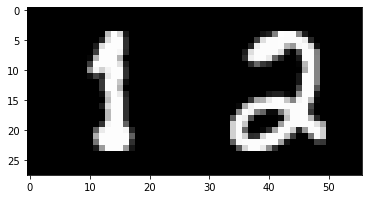

In [ ]:
# Randomly display an example from the new dataset formed.
random = np.random.randint(dataset_size)
plt.imshow(x[random], cmap = 'gray')
print(y[random])

In [ ]:
def ml_split(x, y):
    '''
    Multi hot encode the target variable and divide the data into train, validation and test data.
    '''
    # ml = MultiLabelBinarizer()
    # y = ml.fit_transform(y)

    X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

    ml = MultiLabelBinarizer()
    y_train = ml.fit_transform(y_train)
    y_valid = ml.transform(y_valid)
    y_test = ml.transform(y_test)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = ml_split(x, y)

In [ ]:
def print_shapes():
    print('Shapes of dataset:')
    print('Training dataset:')
    print(X_train.shape, y_train.shape)
    print('\nValidation dataset:')
    print(X_valid.shape, y_valid.shape)
    print('\nTesting dataset:')
    print(X_test.shape, y_test.shape)

In [ ]:
def format_input(features, labels):
    '''
    convert the numpy array (images), labels to tensor objects for training, add the channel dimension to the images.
    '''
    # features = tf.convert_to_tensor(features)
    features = tf.expand_dims(features, axis = -1)

    # labels = tf.convert_to_tensor(labels)

    return features, labels

In [ ]:
X_train, y_train = format_input(X_train, y_train)
X_valid, y_valid = format_input(X_valid, y_valid)
X_test, y_test = format_input(X_test, y_test)

print_shapes()

Shapes of dataset:
Training dataset:
(5746, 28, 56, 1) (5746, 10)

Validation dataset:
(1796, 28, 56, 1) (1796, 10)

Testing dataset:
(1437, 28, 56, 1) (1437, 10)


In [ ]:
def resize(images):
    images = tf.image.resize(images, (100, 100))
    images = tf.image.grayscale_to_rgb(images)

    return images
new_train = []
for image in X_train:
    new_train.append(resize(image))
X_train = np.array(new_train)

new_valid = []
for image in X_valid:
    new_valid.append(resize(image))
X_valid = np.array(new_valid)

new_test = []
for image in X_test:
    new_test.append(resize(image))
X_test = np.array(new_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


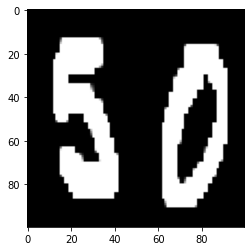

In [ ]:
# a = np.reshape(X_train[0], (100, 100))
plt.imshow(X_train[0])

In [ ]:
def create_generator(bath_size):
    '''
    Creating generators for augmenting (none is mentioned right now), reshaping the data and for easy flow of data to the model.
    '''
    train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, dtype = 'float')
    train_datagen.fit(X_train)

    # valid_datagen = ImageDataGenerator(rescale = 1.0/255., dtype = 'float')

    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle = True, seed = 42)
    valid_generator = train_datagen.flow(X_valid, y_valid, batch_size=batch_size, seed = 42)
    test_generator = train_datagen.flow(X_test, y_test, batch_size=batch_size, seed = 42)

    return train_generator, valid_generator, test_generator

In [ ]:
batch_size = 128
train_generator, valid_generator, test_generator = create_generator(batch_size)

In [ ]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# input_layer = Input(shape= (28, 56, 1))

# sampling_layer = UpSampling2D((4, 2))(input_layer)
# rgb_layer = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(100, 100, 3),
                                include_top=False,
                                weights= None)

# load pre-trained weights
pre_trained_model.load_weights(weights_file)

# freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 768)


In [ ]:
# Flatten the output layer to 1 dimension
x = Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = Dense(10, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

In [ ]:
# # define cnn model
# def define_model(shape=(28, 56, 1), num_classes=10):
#     '''
#     Function to create model.
#     '''
#     model = tf.keras.models.Sequential()
#     model.add(Conv2D(32, (3, 3), padding='same', input_shape=shape))
#     model.add(Activation('relu'))
#     model.add(Conv2D(32, (3, 3), padding='same'))
#     model.add(MaxPooling2D((2, 2)))
# 	# model.add(Dropout(0.2))
#     model.add(Activation('relu'))
#     model.add(Conv2D(64, (3, 3), padding='same'))
#     model.add(Conv2D(64, (3, 3), padding='same'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Activation('relu'))
# 	# model.add(Dropout(0.2))
#     model.add(Conv2D(128, (3, 3), padding='same'))
#     model.add(Conv2D(128, (3, 3), padding='same'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Activation('relu'))
# 	# model.add(Dropout(0.2))
#     model.add(Conv2D(256, (3, 3), padding='same'))
#     model.add(Conv2D(256, (3, 3), padding='same'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Activation('relu'))
    
#     model.add(Flatten())
#     model.add(Dense(512, activation = 'relu'))
#     model.add(Activation('relu'))
#     model.add(Dense(256, activation = 'relu'))
#     model.add(Activation('relu'))
#     model.add(Dense(128, activation = 'relu'))
#     model.add(Dense(64, activation = 'relu'))
# 	# model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='sigmoid'))
    
#     return model
    
# model = define_model()

In [ ]:
model.summary() # display model summary

In [ ]:
plot_model(model, show_shapes = True)  # plot model

In [ ]:
def print_evaluate():
    train_acc = hist.history['accuracy']
    train_loss = hist.history['loss']

    valid_acc = hist.history['val_accuracy']
    valid_loss = hist.history['val_loss']
    epochs = range(len(train_acc))

    plt.plot(epochs, train_acc, 'r', label = 'Train Accuracy',)
    plt.plot(epochs, valid_acc, 'b', label = 'Validation Accuracy')
    # plt.plot(epochs, 0.75, 'y', label = 'Boundary')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    plt.plot(epochs, train_loss, 'r', label = 'Train Loss')
    plt.plot(epochs, valid_loss, 'b', label = 'Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    loss, accuracy = model.evaluate(test_generator, batch_size = batch_size)
    print(loss)
    print(int(accuracy * 100), '%')

In [ ]:
# Define callbacks for the model, so that we can stop the training when required conditions are met.

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.75):
            print("\nReached 75% accuracy so cancelling training!")
            self.model.stop_training = True

    # def on_train_end(self, logs=None):
        # train_acc = hist.history['accuracy']
        # train_loss = hist.history['loss']

        # valid_acc = hist.history['val_accuracy']
        # valid_loss = hist.history['val_loss']
        # epochs = range(len(train_acc))

        # plt.plot(epochs, train_acc, 'r', label = 'Train Accuracy',)
        # plt.plot(epochs, valid_acc, 'b', label = 'Validation Accuracy')
        # # plt.plot(epochs, 0.75, 'y', label = 'Boundary')
        # plt.legend()
        # plt.title('Accuracy')
        # plt.show()

        # plt.plot(epochs, train_loss, 'r', label = 'Train Loss')
        # plt.plot(epochs, valid_loss, 'b', label = 'Validation Loss')
        # plt.legend()
        # plt.title('Loss')
        # plt.show()

        # loss, accuracy = model.evaluate(test_generator, batch_size = batch_size)
        # print(loss)
        # print(int(accuracy * 100), '%')

es = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 25, verbose = 1, restore_best_weights=True,
                                      min_delta = 0.02)
callbacks = myCallback()

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))

In [ ]:
opt = tf.keras.optimizers.RMSprop() #0.0001, momentum = 0.9
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:
epochs = 200

hist = model.fit(train_generator, epochs = epochs, validation_data = valid_generator, callbacks=[callbacks])

Epoch 1/200
45/45 [==============================] - 5s 118ms/step - loss: 0.0372 - accuracy: 0.5675 - val_loss: 0.1313 - val_accuracy: 0.5206
Epoch 2/200
45/45 [==============================] - 5s 115ms/step - loss: 0.0276 - accuracy: 0.5620 - val_loss: 0.1043 - val_accuracy: 0.5651
Epoch 3/200
45/45 [==============================] - 5s 113ms/step - loss: 0.0361 - accuracy: 0.5613 - val_loss: 0.0941 - val_accuracy: 0.5429
Epoch 4/200
45/45 [==============================] - 5s 113ms/step - loss: 0.0256 - accuracy: 0.5597 - val_loss: 0.0993 - val_accuracy: 0.5546
Epoch 5/200
45/45 [==============================] - 5s 113ms/step - loss: 0.0183 - accuracy: 0.5526 - val_loss: 0.1102 - val_accuracy: 0.5601
Epoch 6/200
45/45 [==============================] - 5s 113ms/step - loss: 0.0215 - accuracy: 0.5548 - val_loss: 0.1060 - val_accuracy: 0.5490
Epoch 7/200
45/45 [==============================] - 5s 111ms/step - loss: 0.0210 - accuracy: 0.5541 - val_loss: 0.1039 - val_accuracy: 0.5490

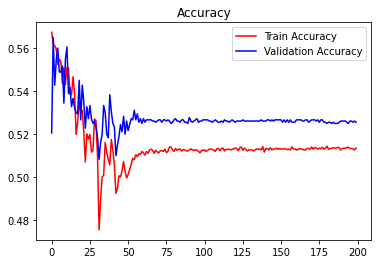

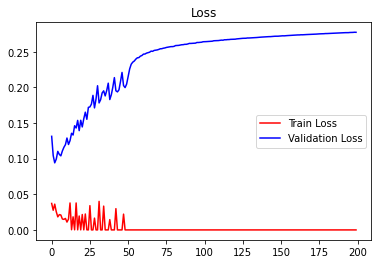

12/12 [==============================] - 1s 79ms/step - loss: 0.2634 - accuracy: 0.5024
0.26343390345573425
50 %


In [ ]:
print_evaluate()

In [ ]:
# model.save('mnist-2-2.h5')